# Load data

In [1]:
#load data
import pandas as pd


### Filter loaded data

In [3]:
dtypesBvot = {
    'NUMTOUR' :    'int64',
    'CODDPT' :    'object',
    'CODSUBCOM' :  'int64',
    'LIBSUBCOM' : 'object',
    'CODBURVOT' : 'object',
    'CODCAN' :     'int64',
    'LIBCAN' :    'object',
    'NBRINS' :     'int64',
    'NBRVOT' :     'int64',
    'NBREXP' :     'int64',
    'NUMDEPCAND' : 'int64',
    'LIBLISEXT' : 'object',
    'CODNUA' :    'object',
    'NBRVOIX' :    'int64',
}

departements = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
                '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
                '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', 
                '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', 
                '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95']

################################# Load data #################################
def loadDatas(dataPaths, sep=';', dtype=dtypesBvot, col_dep='CODDPT', col_tour='NUMTOUR'):
    dataT1Bvot = pd.DataFrame()
    dataT2Bvot = pd.DataFrame()
    for path in dataPaths:
        dataBvot = pd.read_csv(path, sep=sep, dtype=dtype)
        dataBvot = dataBvot[dataBvot[col_dep].isin(departements)]
        dataT1Bvot = pd.concat([dataT1Bvot ,dataBvot[dataBvot[col_tour]==1]])
        dataT2Bvot = pd.concat([dataT1Bvot ,dataBvot[dataBvot[col_tour]==2]])

    return dataT1Bvot, dataT2Bvot

################################# fonction utile #############################
def saveData(data, loc):
    # save cher_data as excel
    writer = pd.ExcelWriter(loc)
    
    # write dataframe to excel
    data.to_excel(writer)

    # save the excel
    writer.save()



############################# Format des donnees brute ##############################

def getNbBinomes(data):
    return len([header for header in data.columns if "Binôme" in header])

def explodeLines(data):
    initdf = data[['Code du département', 'Libellé du département', 'Code du canton', 
            'Libellé du canton', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
            '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
            '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot']]

    headers = ['N°Panneau', 'Nuance', 'Binôme', 'Sièges', 'Voix', '% Voix/Ins', '% Voix/Exp']
    
    df = pd.DataFrame()
    for i in range(getNbBinomes(data)):
        partidf = data[[h+'.'+str(i) if i!=0 else h for h in headers]]
        partidf = pd.concat([initdf, partidf], axis=1)
        partidf.columns = pd.Index(initdf.columns.values.tolist() + headers)
        df = pd.concat([df, partidf])
    
    # Remove useless rows   
    df = df.dropna(how='all', subset=headers)
    
    return df

In [4]:



loadDataPath = ['../dataset/raw/DP15_Bvot_T1T2.csv']

#load data
dataT1Bvot, dataT2Bvot = loadDatas(loadDataPath)

assert dataT1Bvot.shape != (0,0) and dataT2Bvot.shape != (0,0)

# Dictionnaire des duels

In [5]:
#################################### Dictionnaire des duels #####################################

def getNuanceOfElected(data, col_siege='Sièges', col_nuance='Nuance'):
    elected = data[data[col_siege]=='Elus']
    return list(elected[col_nuance]) if len(elected)!=0 else None

def filterBestNuances(data, col_nuance='Nuance', criteria=12.50):
    bestCandidat = data[data['% Voix/Ins']>= criteria]
    
    if bestCandidat.empty or len(bestCandidat)==1:
        bestCandidat = data.sort_values(by='Voix', ascending=False).iloc[0:2,:]

    return list(bestCandidat[col_nuance])

def getDuelsFromDep(data_dep, col_dep='CODDPT', col_canton='CODCAN', col_nuance='CODNUA'):
    '''
        return : {'canton_1':[P1,...,P_k], ..., 'canton_n':[P1,...,P_K]}, 
                                        ..., 
                    'canton_N':[P1,...,P_i], ..., 'canton_m':[P1,...,P_I]}
                  }
    '''
    duels = dict()
    for canton in data_dep[col_canton].unique():
        data_canton = data_dep[data_dep[col_canton]==canton]
        duels[str(canton)]= list(data_canton[col_nuance].unique())
    return duels 

def optimizedDuelDict(duels):
    '''
        return : {'duel_1':{'dep':[canton],..., 'duel_n':[canton]},
                            ...,
                  'duel_N':{'dep':[canton],..., 'duel_n':[canton]}
                  }
            avec :
                  - duel = 'P1:P2:...:Pn'
    '''
    optdict = dict()
    for dep, duelDepDict in duels.items():
        for canton, duelList in duelDepDict.items():
            key = ':'.join(sorted(duelList))
            if key in optdict.keys():                
                if dep in optdict[key].keys():
                    optdict[key][dep].append(int(canton))
                else:
                    optdict[key][dep]=[int(canton)]
            else:
                optdict[key]= dict([(dep, [int(canton)])])
    return optdict

In [6]:
#dictionnaire des duels
duels = dict()
for dep in dataT2Bvot['CODDPT'].unique():
    duels[str(dep)]= getDuelsFromDep(dataT2Bvot[dataT2Bvot['CODDPT']==dep])
    if duels[str(dep)]==[]:
        print('empty list for dep : ', dep)

#dictionnaire ooptimize
optDuels = optimizedDuelDict(duels)

In [31]:
len(optDuels)

99

# Preparation des donnees et entrainement du reseau de neuronne

In [7]:
#################################### Data Processing ####################################

def prepareInputDataExploded(data):
    tmp = data[['NUMTOUR', 'CODDPT', 'CODSUBCOM', 'LIBSUBCOM', 'CODBURVOT', 'CODCAN',
            'LIBCAN', 'NBRINS', 'NBRVOT', 'NBREXP', 'CODNUA', 'NBRVOIX']].copy()

    # Compute missing data
    tmp['NBRABS'] = tmp['NBRINS'] - tmp['NBRVOT']
    tmp['NBRBLCNUL'] = tmp['NBRVOT'] - tmp['NBREXP']
    tmp['%ABS/INS'] = tmp['NBRABS'] / tmp['NBRINS']
    tmp['%BLCNUL/VOT'] = tmp['NBRBLCNUL'] / tmp['NBRVOT']
    tmp['%EXP/VOT'] = tmp['NBREXP'] / tmp['NBRVOT']
    tmp['%VOIX/EXP'] = tmp['NBRVOIX'] / tmp['NBREXP']

    nuances = getAllNuances()
    statsFeatures = ['NBRINS', 'NBREXP', '%ABS/INS', '%BLCNUL/VOT', '%EXP/VOT']
    idFeatures = ['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']

    exprimes = tmp[idFeatures + ['NBREXP']].drop_duplicates().sort_values(idFeatures)['NBREXP']
    stats = tmp[idFeatures + statsFeatures].drop_duplicates()[statsFeatures]
    ids = tmp[idFeatures].drop_duplicates()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in data.CODNUA.unique():
        voix[parti][data['CODNUA']==parti] = tmp[tmp['CODNUA']==parti]['NBRVOIX']
    voix = pd.concat([tmp[idFeatures], voix], axis=1).groupby(idFeatures).sum()[nuances]
    voix.index = exprimes.index

    # Concat with computed stats and divide almost everything by Exprimés
    voix = voix.divide(exprimes, axis=0)
    X = pd.concat([stats, voix], axis=1)
    X.index = pd.MultiIndex.from_frame(ids)
    return X.sort_values(['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']).fillna(0)

def getAllNuances(data=dataT1Bvot, colNuance='CODNUA', fmt='exploded'):
    if fmt not in ['exploded', 'line']:
        raise ValueError("format parameter must be 'exploded' or 'line'")
    
    if fmt == 'exploded':
        nuances = data[colNuance].unique()
    
    if fmt == 'line':
        nuances = np.array([])
        nuances_tmp = data[colNuance].fillna(0)
        for c in nuances_tmp:
            nuances = np.append(nuances, nuances_tmp[c])
        nuances = np.unique(nuances[nuances!=0])
    
    return sorted(nuances)

# retourne un dataset associe a un duel
def extractDuelRaw(duel, X=dataT1Bvot, y=dataT2Bvot, col_canton='CODCAN', col_dep='CODDPT'):
    correction = [str(i) for i in range(1,10)]
    X_duel = pd.DataFrame()
    y_duel = pd.DataFrame()

    #remove canton where there is a winner in the 1st turn
    for dep, cantonList in optDuels[':'.join(sorted(duel))].items():
        X_duel = pd.concat([X_duel, X.loc[( X[col_dep] == (dep if dep not in correction else '0'+dep) ) & ( X[col_canton].isin(cantonList) )]])
        y_duel = pd.concat([y_duel, y.loc[( y[col_dep] == (dep if dep not in correction else '0'+dep) ) & ( y[col_canton].isin(cantonList) )]])
    
    return (X_duel, y_duel)

def prepareLabelsExploded(data, oneHotEncode=False):
    nuances = getAllNuances(data)
    idFeatures = ['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']

    exprimes = data[idFeatures+['NBREXP']].groupby(idFeatures).first()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in nuances:
        voix[parti][data['CODNUA']==parti] = data[data['CODNUA']==parti]['NBRVOIX']
    voix = pd.concat([data[idFeatures], voix], axis=1).groupby(idFeatures).sum().sort_values(idFeatures)[nuances]

    # Concat with computed stats and divide voix by exprimes
    y = voix.divide(exprimes['NBREXP'], axis=0)
    return y.fillna(0)

In [8]:
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

def testna(data):
    return len(data[data.isna().any(axis=1)])


def getTestAccuracy(duel):
    return models[duel]['accuracy'][1]

def getTrainAccuracy(duel):
    return models[duel]['accuracy'][0]

def getActivation(duel):
    return models[duel]['activation']

def getLoss(duel):
    return models[duel]['loss']

def getHistory(duel):
    return models[duel]['history']

def getModel(duel):
    return models[duel]['model']

def criteriaRespected(test_acc, loss, test_criteria=0.75, loss_criteria=0.14):
    return test_acc >= test_criteria and loss <=loss_criteria

def betterModel(duel, test_acc, loss, epsilon=0.001):
    current_acc = getTestAccuracy(duel)
    current_loss = getLoss(duel)
    return test_acc >= current_acc and loss<=current_loss + epsilon
    
def saveModel(model, duel, activation):
    model_path = 'models/'+activation+'/'+duel.replace(':','_')
    model.save(model_path)

    



---------------------------------------- Duel : BC-FN:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.940, Test: 0.937 loss:0.0025
elu function is not better Train: 0.859, Test: 0.854 loss:0.0034
selu function is not better Train: 0.940, Test: 0.932 loss:0.0030
INFO:tensorflow:Assets written to: models/relu/BC-FN_BC-UD/assets
Train: 0.940, Test: 0.937 loss:0.0025 activation: relu


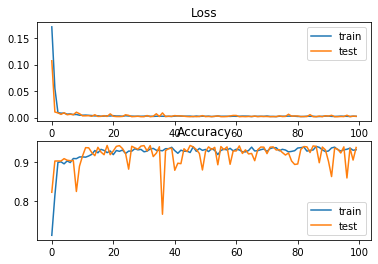

shape xtrain (10004, 24) shape ytrain (10004, 2) || shape xtest (2502, 24) shape ytest (2502, 2)
Progression........................................................................... 1.01%

---------------------------------------- Duel : BC-FN:BC-UD:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.738, Test: 0.751 loss:0.0087
elu funtion is worst ! Train: 0.760, Test: 0.744 loss:0.0470
selu funtion is worst ! Train: 0.542, Test: 0.537 loss:0.0718
INFO:tensorflow:Assets written to: models/relu/BC-FN_BC-UD_BC-UG/assets
Train: 0.738, Test: 0.751 loss:0.0087 activation: relu


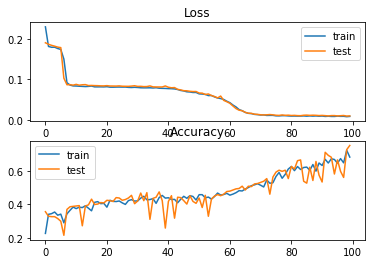

shape xtrain (1760, 24) shape ytrain (1760, 3) || shape xtest (441, 24) shape ytest (441, 3)
Progression........................................................................... 2.02%

---------------------------------------- Duel : BC-FN:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.885, Test: 0.881 loss:0.0065
elu function is better Train: 0.908, Test: 0.913 loss:0.0024
selu funtion is worst ! Train: 0.781, Test: 0.774 loss:0.1868
INFO:tensorflow:Assets written to: models/elu/BC-FN_BC-UG/assets
Train: 0.908, Test: 0.913 loss:0.0024 activation: elu


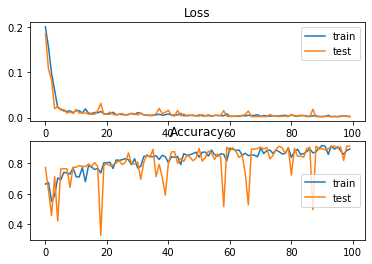

shape xtrain (1877, 24) shape ytrain (1877, 2) || shape xtest (470, 24) shape ytest (470, 2)
Progression........................................................................... 3.03%

---------------------------------------- Duel : BC-UD:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.897, Test: 0.892 loss:0.0032
elu function is better Train: 0.922, Test: 0.924 loss:0.0021
selu function is not better Train: 0.910, Test: 0.914 loss:0.0019
INFO:tensorflow:Assets written to: models/elu/BC-UD_BC-UG/assets
Train: 0.922, Test: 0.924 loss:0.0021 activation: elu


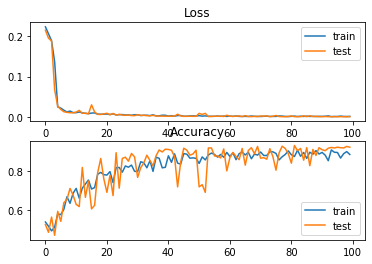

shape xtrain (3104, 24) shape ytrain (3104, 2) || shape xtest (777, 24) shape ytest (777, 2)
Progression........................................................................... 4.04%

---------------------------------------- Duel : BC-FN:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.934, Test: 0.927 loss:0.0032
elu function is better Train: 0.948, Test: 0.949 loss:0.0024
selu function is not better Train: 0.939, Test: 0.933 loss:0.0047
INFO:tensorflow:Assets written to: models/elu/BC-FN_BC-UMP/assets
Train: 0.948, Test: 0.949 loss:0.0024 activation: elu


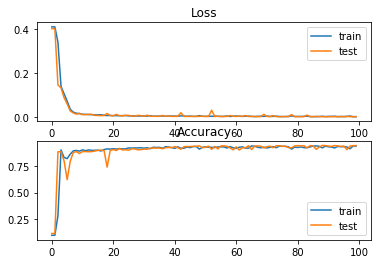

shape xtrain (3466, 24) shape ytrain (3466, 2) || shape xtest (867, 24) shape ytest (867, 2)
Progression........................................................................... 5.05%

---------------------------------------- Duel : BC-FN:BC-SOC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.863, Test: 0.861 loss:0.0024
elu function is better Train: 0.917, Test: 0.919 loss:0.0021
selu function is not better Train: 0.913, Test: 0.910 loss:0.0029
INFO:tensorflow:Assets written to: models/elu/BC-FN_BC-SOC/assets
Train: 0.917, Test: 0.919 loss:0.0021 activation: elu


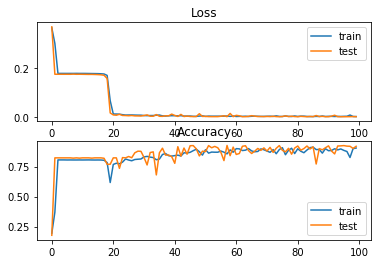

shape xtrain (3519, 24) shape ytrain (3519, 2) || shape xtest (880, 24) shape ytest (880, 2)
Progression........................................................................... 6.06%

---------------------------------------- Duel : BC-FN:BC-UDI --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.913, Test: 0.901 loss:0.0091
elu function is better Train: 0.918, Test: 0.901 loss:0.0059
selu function is better Train: 0.925, Test: 0.915 loss:0.0063
INFO:tensorflow:Assets written to: models/selu/BC-FN_BC-UDI/assets
Train: 0.925, Test: 0.915 loss:0.0063 activation: selu


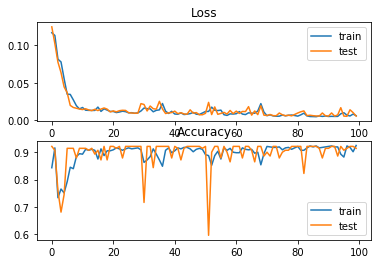

shape xtrain (563, 24) shape ytrain (563, 2) || shape xtest (141, 24) shape ytest (141, 2)
Progression........................................................................... 7.07%

---------------------------------------- Duel : BC-COM:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.583, Test: 0.143 loss:0.2216
elu funtion is worst ! Train: 0.625, Test: 0.143 loss:0.1173
selu funtion is worst ! Train: 0.458, Test: 0.143 loss:0.1178
no model for this duel !
shape xtrain (24, 24) shape ytrain (24, 2) || shape xtest (7, 24) shape ytest (7, 2)
Progression........................................................................... 8.08%

---------------------------------------- Duel : BC-DVD:BC-FG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.739, Test: 0.727 loss:0.2097
elu funtion is worst ! Train: 0.580, Test: 0.364 loss:0.0749
sel

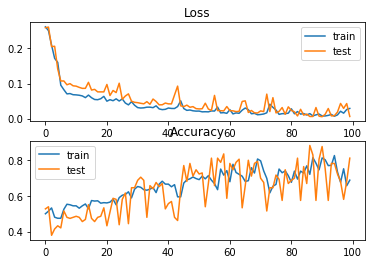

shape xtrain (675, 24) shape ytrain (675, 2) || shape xtest (169, 24) shape ytest (169, 2)
Progression........................................................................... 10.10%

---------------------------------------- Duel : BC-COM:BC-DVD:BC-FN --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.769, Test: 0.429 loss:0.1200
elu funtion is worst ! Train: 0.192, Test: 0.000 loss:0.0967
selu funtion is worst ! Train: 0.192, Test: 0.000 loss:0.2073
no model for this duel !
shape xtrain (26, 24) shape ytrain (26, 3) || shape xtest (7, 24) shape ytest (7, 3)
Progression........................................................................... 11.11%

---------------------------------------- Duel : BC-DVD:BC-FN:BC-RDG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.538, Test: 0.286 loss:0.1913
elu funtion is worst ! Train: 0.462, Test: 0.571

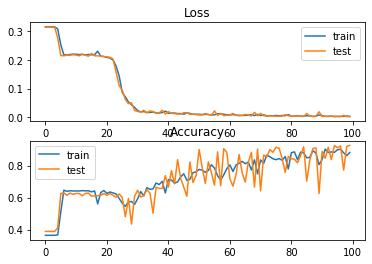

shape xtrain (1397, 24) shape ytrain (1397, 2) || shape xtest (350, 24) shape ytest (350, 2)
Progression........................................................................... 14.14%

---------------------------------------- Duel : BC-DVD:BC-FN --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.919, Test: 0.928 loss:0.0044
elu function is not better Train: 0.922, Test: 0.925 loss:0.0038
selu function is not better Train: 0.921, Test: 0.923 loss:0.0058
INFO:tensorflow:Assets written to: models/relu/BC-DVD_BC-FN/assets
Train: 0.919, Test: 0.928 loss:0.0044 activation: relu


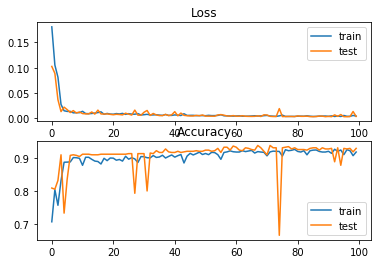

shape xtrain (2279, 24) shape ytrain (2279, 2) || shape xtest (570, 24) shape ytest (570, 2)
Progression........................................................................... 15.15%

---------------------------------------- Duel : BC-FN:BC-SOC:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.701, Test: 0.684 loss:0.0487
elu function used for the new model Train: 0.836, Test: 0.825 loss:0.0038
selu function is not better Train: 0.783, Test: 0.752 loss:0.0032
INFO:tensorflow:Assets written to: models/elu/BC-FN_BC-SOC_BC-UMP/assets
Train: 0.836, Test: 0.825 loss:0.0038 activation: elu


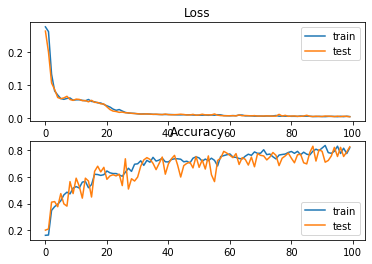

shape xtrain (932, 24) shape ytrain (932, 3) || shape xtest (234, 24) shape ytest (234, 3)
Progression........................................................................... 16.16%

---------------------------------------- Duel : BC-DVG:BC-FN --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.862, Test: 0.867 loss:0.0050
elu function is not better Train: 0.798, Test: 0.823 loss:0.0116
selu function is not better Train: 0.881, Test: 0.881 loss:0.0060
INFO:tensorflow:Assets written to: models/relu/BC-DVG_BC-FN/assets
Train: 0.862, Test: 0.867 loss:0.0050 activation: relu


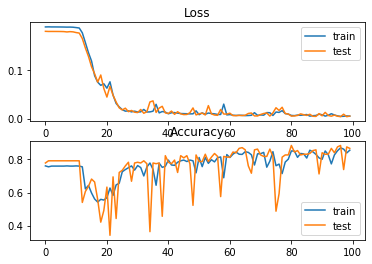

shape xtrain (904, 24) shape ytrain (904, 2) || shape xtest (226, 24) shape ytest (226, 2)
Progression........................................................................... 17.17%

---------------------------------------- Duel : BC-SOC:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.912, Test: 0.904 loss:0.0021
elu funtion is worst ! Train: 0.635, Test: 0.633 loss:0.0032
selu funtion is worst ! Train: 0.476, Test: 0.474 loss:0.2723
INFO:tensorflow:Assets written to: models/relu/BC-SOC_BC-UD/assets
Train: 0.912, Test: 0.904 loss:0.0021 activation: relu


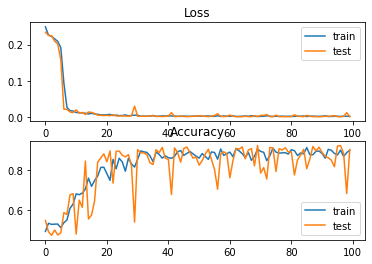

shape xtrain (4565, 24) shape ytrain (4565, 2) || shape xtest (1142, 24) shape ytest (1142, 2)
Progression........................................................................... 18.18%

---------------------------------------- Duel : BC-FG:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.581, Test: 0.582 loss:0.0128
elu funtion is worst ! Train: 0.668, Test: 0.709 loss:0.1656
selu funtion is worst ! Train: 0.521, Test: 0.582 loss:0.2563
no model for this duel !
shape xtrain (217, 24) shape ytrain (217, 2) || shape xtest (55, 24) shape ytest (55, 2)
Progression........................................................................... 19.19%

---------------------------------------- Duel : BC-EXD:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 1.000, Test: 1.000 loss:0.0154
elu function is not better Train: 1.000, 

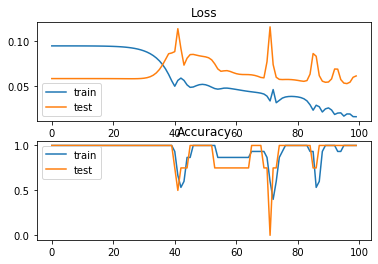

shape xtrain (15, 24) shape ytrain (15, 2) || shape xtest (4, 24) shape ytest (4, 2)
Progression........................................................................... 20.20%

---------------------------------------- Duel : BC-DVD:BC-DVG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.554, Test: 0.480 loss:0.1636
elu function used for the new model Train: 0.819, Test: 0.843 loss:0.0162
selu funtion is worst ! Train: 0.703, Test: 0.735 loss:0.0160
INFO:tensorflow:Assets written to: models/elu/BC-DVD_BC-DVG/assets
Train: 0.819, Test: 0.843 loss:0.0162 activation: elu


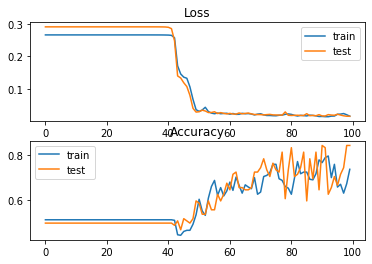

shape xtrain (408, 24) shape ytrain (408, 2) || shape xtest (102, 24) shape ytest (102, 2)
Progression........................................................................... 21.21%

---------------------------------------- Duel : BC-DVG:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.681, Test: 0.698 loss:0.0196
elu function used for the new model Train: 0.835, Test: 0.857 loss:0.0098
selu funtion is worst ! Train: 0.726, Test: 0.730 loss:0.0174
INFO:tensorflow:Assets written to: models/elu/BC-DVG_BC-UMP/assets
Train: 0.835, Test: 0.857 loss:0.0098 activation: elu


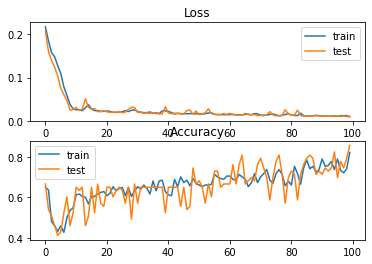

shape xtrain (248, 24) shape ytrain (248, 2) || shape xtest (63, 24) shape ytest (63, 2)
Progression........................................................................... 22.22%

---------------------------------------- Duel : BC-DVG:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.861, Test: 0.860 loss:0.0047
elu funtion is worst ! Train: 0.669, Test: 0.702 loss:0.0038
selu funtion is worst ! Train: 0.520, Test: 0.532 loss:0.0061
INFO:tensorflow:Assets written to: models/relu/BC-DVG_BC-UD/assets
Train: 0.861, Test: 0.860 loss:0.0047 activation: relu


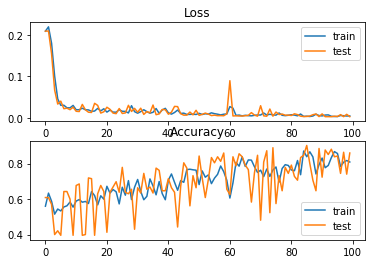

shape xtrain (936, 24) shape ytrain (936, 2) || shape xtest (235, 24) shape ytest (235, 2)
Progression........................................................................... 23.23%

---------------------------------------- Duel : BC-DIV:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.885, Test: 0.692 loss:0.1421
elu funtion is worst ! Train: 0.885, Test: 0.692 loss:0.0215
selu funtion is worst ! Train: 0.885, Test: 0.692 loss:0.1419
no model for this duel !
shape xtrain (52, 24) shape ytrain (52, 2) || shape xtest (13, 24) shape ytest (13, 2)
Progression........................................................................... 24.24%

---------------------------------------- Duel : BC-COM:BC-FN:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.354, Test: 0.476 loss:0.0833
elu funtion is worst ! Train: 0.329, Test: 0.238 loss:

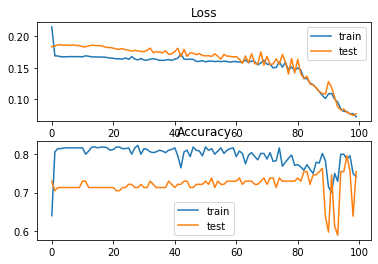

shape xtrain (487, 24) shape ytrain (487, 2) || shape xtest (122, 24) shape ytest (122, 2)
Progression........................................................................... 26.26%

---------------------------------------- Duel : BC-FN:BC-SOC:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.804, Test: 0.805 loss:0.0036
elu function is not better Train: 0.811, Test: 0.796 loss:0.0033
selu funtion is worst ! Train: 0.725, Test: 0.700 loss:0.0038
INFO:tensorflow:Assets written to: models/relu/BC-FN_BC-SOC_BC-UD/assets
Train: 0.804, Test: 0.805 loss:0.0036 activation: relu


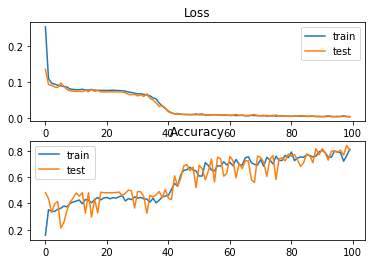

shape xtrain (1743, 24) shape ytrain (1743, 3) || shape xtest (436, 24) shape ytest (436, 3)
Progression........................................................................... 27.27%

---------------------------------------- Duel : BC-DVD:BC-FN:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.547, Test: 0.542 loss:0.0499
elu funtion is worst ! Train: 0.329, Test: 0.407 loss:0.1902
selu funtion is worst ! Train: 0.654, Test: 0.593 loss:0.0479
no model for this duel !
shape xtrain (234, 24) shape ytrain (234, 3) || shape xtest (59, 24) shape ytest (59, 3)
Progression........................................................................... 28.28%

---------------------------------------- Duel : BC-FN:BC-UG:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.427, Test: 0.494 loss:0.0783
elu funtion is worst ! Train: 0.513, Test: 0

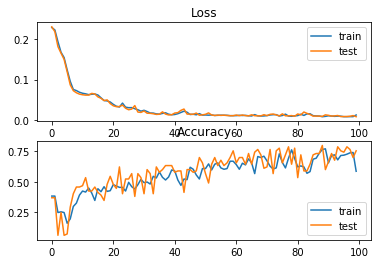

shape xtrain (360, 24) shape ytrain (360, 3) || shape xtest (90, 24) shape ytest (90, 3)
Progression........................................................................... 33.33%

---------------------------------------- Duel : BC-DVG:BC-SOC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.753, Test: 0.762 loss:0.0316
elu function is better Train: 0.765, Test: 0.786 loss:0.0154
selu function is not better Train: 0.753, Test: 0.762 loss:0.0252
INFO:tensorflow:Assets written to: models/elu/BC-DVG_BC-SOC/assets
Train: 0.765, Test: 0.786 loss:0.0154 activation: elu


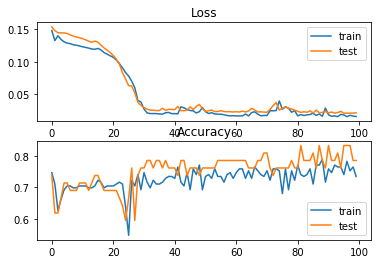

shape xtrain (166, 24) shape ytrain (166, 2) || shape xtest (42, 24) shape ytest (42, 2)
Progression........................................................................... 34.34%

---------------------------------------- Duel : BC-DVD:BC-FN:BC-SOC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.804, Test: 0.814 loss:0.0078
elu function is not better Train: 0.803, Test: 0.792 loss:0.0046
selu function is better Train: 0.828, Test: 0.836 loss:0.0066
INFO:tensorflow:Assets written to: models/selu/BC-DVD_BC-FN_BC-SOC/assets
Train: 0.828, Test: 0.836 loss:0.0066 activation: selu


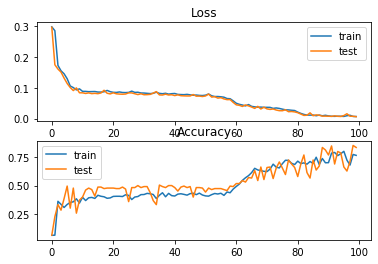

shape xtrain (900, 24) shape ytrain (900, 3) || shape xtest (226, 24) shape ytest (226, 3)
Progression........................................................................... 35.35%

---------------------------------------- Duel : BC-RDG:BC-UDI --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.632, Test: 0.400 loss:0.2369
elu funtion is worst ! Train: 0.368, Test: 0.600 loss:0.2946
selu funtion is worst ! Train: 0.632, Test: 0.400 loss:0.2369
no model for this duel !
shape xtrain (19, 24) shape ytrain (19, 2) || shape xtest (5, 24) shape ytest (5, 2)
Progression........................................................................... 36.36%

---------------------------------------- Duel : BC-SOC:BC-UDI --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.404, Test: 0.603 loss:0.2180
elu funtion is worst ! Train: 0.426, Test: 0.621 loss:0.0204

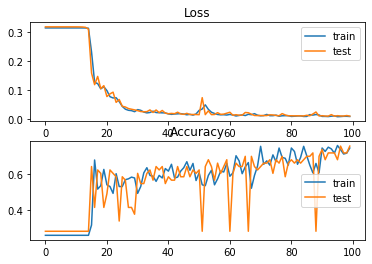

shape xtrain (211, 24) shape ytrain (211, 2) || shape xtest (53, 24) shape ytest (53, 2)
Progression........................................................................... 40.40%

---------------------------------------- Duel : BC-MDM:BC-SOC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.444, Test: 0.429 loss:0.0623
elu function used for the new model Train: 0.667, Test: 0.786 loss:0.0216
selu funtion is worst ! Train: 0.667, Test: 0.643 loss:0.1692
INFO:tensorflow:Assets written to: models/elu/BC-MDM_BC-SOC/assets
Train: 0.667, Test: 0.786 loss:0.0216 activation: elu


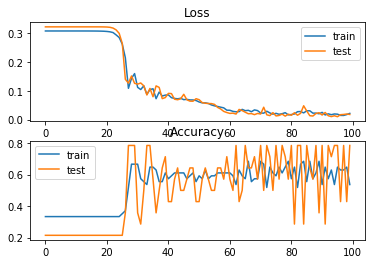

shape xtrain (54, 24) shape ytrain (54, 2) || shape xtest (14, 24) shape ytest (14, 2)
Progression........................................................................... 41.41%

---------------------------------------- Duel : BC-DVD --------------------------------------

---------------------------------------- Duel : BC-DIV:BC-DVD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.709, Test: 0.676 loss:0.0225
elu funtion is worst ! Train: 0.358, Test: 0.412 loss:0.3147
selu funtion is worst ! Train: 0.358, Test: 0.412 loss:0.3147
no model for this duel !
shape xtrain (134, 24) shape ytrain (134, 2) || shape xtest (34, 24) shape ytest (34, 2)
Progression........................................................................... 43.43%

---------------------------------------- Duel : BC-DIV:BC-DVG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Tra

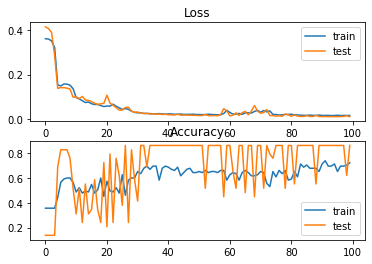

shape xtrain (115, 24) shape ytrain (115, 2) || shape xtest (29, 24) shape ytest (29, 2)
Progression........................................................................... 45.45%

---------------------------------------- Duel : BC-FN:BC-RDG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.000, Test: 0.000 loss:0.3813
elu funtion is worst ! Train: 1.000, Test: 1.000 loss:0.1527
selu function used for the new model Train: 0.964, Test: 1.000 loss:0.0041
INFO:tensorflow:Assets written to: models/selu/BC-FN_BC-RDG/assets
Train: 0.964, Test: 1.000 loss:0.0041 activation: selu


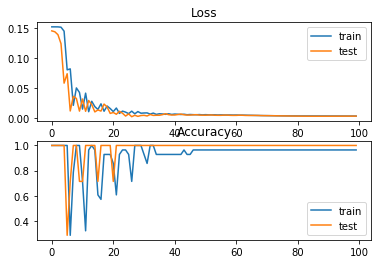

shape xtrain (28, 24) shape ytrain (28, 2) || shape xtest (7, 24) shape ytest (7, 2)
Progression........................................................................... 46.46%

---------------------------------------- Duel : BC-FG:BC-FN --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.784, Test: 0.815 loss:0.0084
elu function is not better Train: 0.782, Test: 0.815 loss:0.0155
selu funtion is worst ! Train: 0.239, Test: 0.200 loss:0.3591
INFO:tensorflow:Assets written to: models/relu/BC-FG_BC-FN/assets
Train: 0.784, Test: 0.815 loss:0.0084 activation: relu


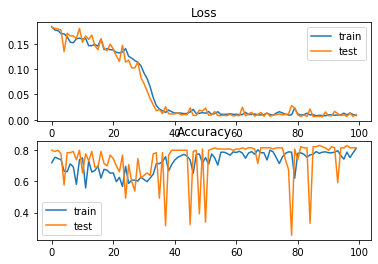

shape xtrain (518, 24) shape ytrain (518, 2) || shape xtest (130, 24) shape ytest (130, 2)
Progression........................................................................... 47.47%

---------------------------------------- Duel : BC-RDG:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.493, Test: 0.412 loss:0.1272
elu funtion is worst ! Train: 0.809, Test: 0.647 loss:0.0198
selu funtion is worst ! Train: 0.566, Test: 0.471 loss:0.0849
no model for this duel !
shape xtrain (136, 24) shape ytrain (136, 2) || shape xtest (34, 24) shape ytest (34, 2)
Progression........................................................................... 48.48%

---------------------------------------- Duel : BC-UDI:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.294, Test: 0.800 loss:0.2559
elu funtion is worst ! Train: 0.353, Test: 0.800 loss:0.27

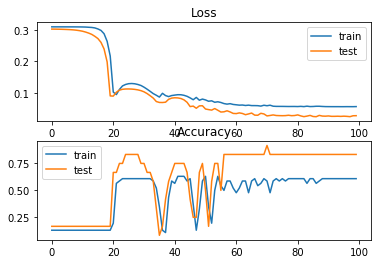

shape xtrain (46, 24) shape ytrain (46, 3) || shape xtest (12, 24) shape ytest (12, 3)
Progression........................................................................... 55.56%

---------------------------------------- Duel : BC-DVG:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.650, Test: 0.528 loss:0.1000
elu funtion is worst ! Train: 0.650, Test: 0.722 loss:0.1206
selu funtion is worst ! Train: 0.692, Test: 0.639 loss:0.1939
no model for this duel !
shape xtrain (143, 24) shape ytrain (143, 2) || shape xtest (36, 24) shape ytest (36, 2)
Progression........................................................................... 56.57%

---------------------------------------- Duel : BC-UMP:BC-VEC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.533, Test: 0.250 loss:0.0591
elu funtion is worst ! Train: 0.500, Test: 0.250 loss:0.2502


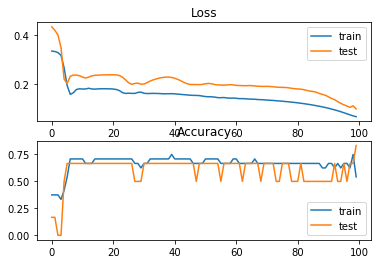

shape xtrain (24, 24) shape ytrain (24, 2) || shape xtest (6, 24) shape ytest (6, 2)
Progression........................................................................... 60.61%

---------------------------------------- Duel : BC-FG --------------------------------------

---------------------------------------- Duel : BC-FN:BC-MDM --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 1.000, Test: 1.000 loss:0.0805
elu function is better Train: 1.000, Test: 1.000 loss:0.0035
selu function is not better Train: 1.000, Test: 1.000 loss:0.0805
INFO:tensorflow:Assets written to: models/elu/BC-FN_BC-MDM/assets
Train: 1.000, Test: 1.000 loss:0.0035 activation: elu


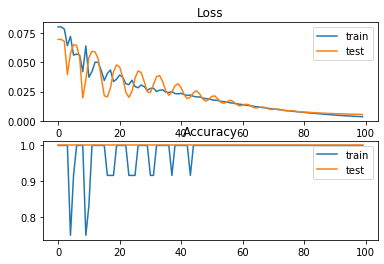

shape xtrain (12, 24) shape ytrain (12, 2) || shape xtest (4, 24) shape ytest (4, 2)
Progression........................................................................... 62.63%

---------------------------------------- Duel : BC-DVG:BC-FN:BC-UDI --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.270, Test: 0.421 loss:0.1448
elu funtion is worst ! Train: 0.568, Test: 0.421 loss:0.0600
selu funtion is worst ! Train: 0.351, Test: 0.316 loss:0.0576
no model for this duel !
shape xtrain (74, 24) shape ytrain (74, 3) || shape xtest (19, 24) shape ytest (19, 3)
Progression........................................................................... 63.64%

---------------------------------------- Duel : BC-DVD:BC-FN:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.448, Test: 0.294 loss:0.0828
elu funtion is worst ! Train: 0.657, Test: 0.706 loss

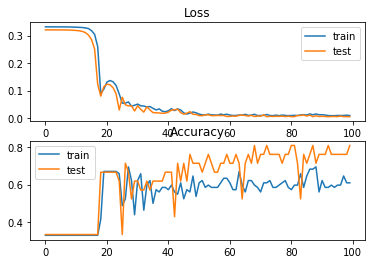

shape xtrain (82, 24) shape ytrain (82, 2) || shape xtest (21, 24) shape ytest (21, 2)
Progression........................................................................... 67.68%

---------------------------------------- Duel : BC-DVG:BC-FG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.857, Test: 0.889 loss:0.1886
elu funtion is worst ! Train: 0.857, Test: 0.889 loss:0.1886
selu function used for the new model Train: 0.714, Test: 0.778 loss:0.0873
INFO:tensorflow:Assets written to: models/selu/BC-DVG_BC-FG/assets
Train: 0.714, Test: 0.778 loss:0.0873 activation: selu


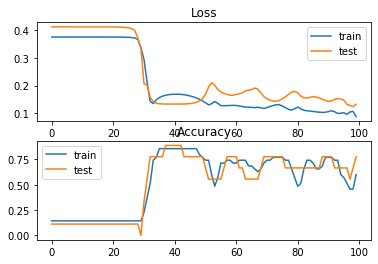

shape xtrain (35, 24) shape ytrain (35, 2) || shape xtest (9, 24) shape ytest (9, 2)
Progression........................................................................... 68.69%

---------------------------------------- Duel : BC-MDM:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.400, Test: 0.800 loss:0.0200
elu funtion is worst ! Train: 0.600, Test: 0.400 loss:0.1832
selu funtion is worst ! Train: 0.500, Test: 0.400 loss:0.2723
INFO:tensorflow:Assets written to: models/relu/BC-MDM_BC-UMP/assets
Train: 0.400, Test: 0.800 loss:0.0200 activation: relu


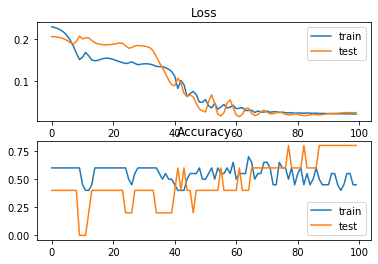

shape xtrain (20, 24) shape ytrain (20, 2) || shape xtest (5, 24) shape ytest (5, 2)
Progression........................................................................... 69.70%

---------------------------------------- Duel : BC-UD:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.600, Test: 0.714 loss:0.0671
elu funtion is worst ! Train: 0.440, Test: 0.571 loss:0.0881
selu funtion is worst ! Train: 0.680, Test: 0.571 loss:0.1681
no model for this duel !
shape xtrain (25, 24) shape ytrain (25, 2) || shape xtest (7, 24) shape ytest (7, 2)
Progression........................................................................... 70.71%

---------------------------------------- Duel : BC-DVD:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.531, Test: 0.568 loss:0.0399
elu funtion is worst ! Train: 0.571, Test: 0.541 loss:0.2407
selu f

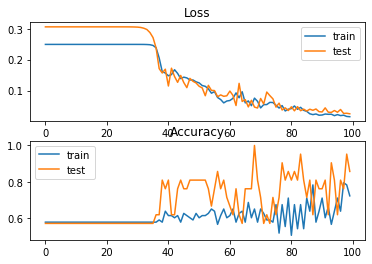

shape xtrain (83, 24) shape ytrain (83, 2) || shape xtest (21, 24) shape ytest (21, 2)
Progression........................................................................... 78.79%

---------------------------------------- Duel : BC-DVG:BC-UC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.646, Test: 0.750 loss:0.0260
elu function is better Train: 0.667, Test: 0.750 loss:0.0265
selu funtion is worst ! Train: 0.354, Test: 0.250 loss:0.3938
INFO:tensorflow:Assets written to: models/elu/BC-DVG_BC-UC/assets
Train: 0.667, Test: 0.750 loss:0.0265 activation: elu


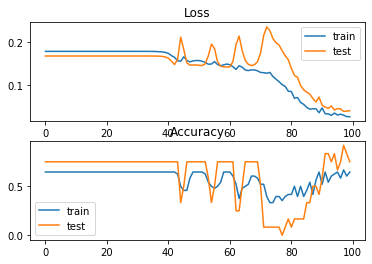

shape xtrain (48, 24) shape ytrain (48, 2) || shape xtest (12, 24) shape ytest (12, 2)
Progression........................................................................... 79.80%

---------------------------------------- Duel : BC-DVG:BC-MDM --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.000, Test: 0.000 loss:0.4906
elu funtion is worst ! Train: 0.000, Test: 0.000 loss:0.4906
selu funtion is worst ! Train: 0.000, Test: 0.000 loss:0.4906
no model for this duel !
shape xtrain (15, 24) shape ytrain (15, 2) || shape xtest (4, 24) shape ytest (4, 2)
Progression........................................................................... 80.81%

---------------------------------------- Duel : BC-DIV:BC-MDM --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.909, Test: 0.833 loss:0.1429
elu function used for the new model Train: 0.909, Test: 0.833 lo

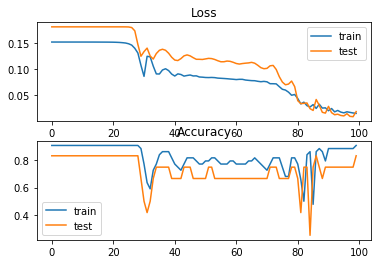

shape xtrain (44, 24) shape ytrain (44, 2) || shape xtest (12, 24) shape ytest (12, 2)
Progression........................................................................... 81.82%

---------------------------------------- Duel : BC-DIV:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.263, Test: 0.400 loss:0.3234
elu funtion is worst ! Train: 0.263, Test: 0.400 loss:0.3234
selu funtion is worst ! Train: 0.684, Test: 0.600 loss:0.1624
no model for this duel !
shape xtrain (19, 24) shape ytrain (19, 2) || shape xtest (5, 24) shape ytest (5, 2)
Progression........................................................................... 82.83%

---------------------------------------- Duel : BC-RDG:BC-UG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu function used for the new model Train: 0.823, Test: 0.938 loss:0.1256
elu function is not better Train: 0.823, Test: 0.875

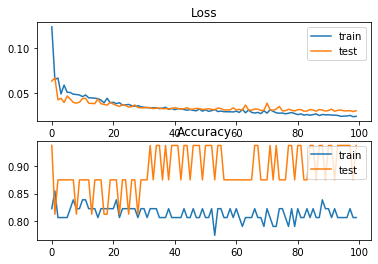

shape xtrain (62, 24) shape ytrain (62, 2) || shape xtest (16, 24) shape ytest (16, 2)
Progression........................................................................... 83.84%

---------------------------------------- Duel : BC-DIV:BC-FN:BC-UD --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.524, Test: 0.333 loss:0.2397
elu funtion is worst ! Train: 0.524, Test: 0.333 loss:0.2397
selu funtion is worst ! Train: 0.524, Test: 0.333 loss:0.2397
no model for this duel !
shape xtrain (21, 24) shape ytrain (21, 3) || shape xtest (6, 24) shape ytest (6, 3)
Progression........................................................................... 84.85%

---------------------------------------- Duel : BC-UDI:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.696, Test: 0.583 loss:0.2012
elu funtion is worst ! Train: 0.696, Test: 0.583 loss:0.201

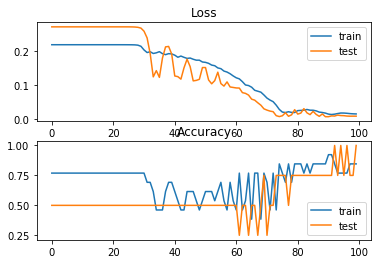

shape xtrain (13, 24) shape ytrain (13, 2) || shape xtest (4, 24) shape ytest (4, 2)
Progression........................................................................... 86.87%

---------------------------------------- Duel : BC-FN:BC-UMP:BC-VEC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.444, Test: 0.571 loss:0.2097
elu funtion is worst ! Train: 0.519, Test: 0.286 loss:0.0800
selu funtion is worst ! Train: 0.444, Test: 0.571 loss:0.2097
no model for this duel !
shape xtrain (27, 24) shape ytrain (27, 3) || shape xtest (7, 24) shape ytest (7, 3)
Progression........................................................................... 87.88%

---------------------------------------- Duel : BC-FG:BC-UDI --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.517, Test: 0.688 loss:0.1774
elu funtion is worst ! Train: 0.733, Test: 0.750 loss:0.1605


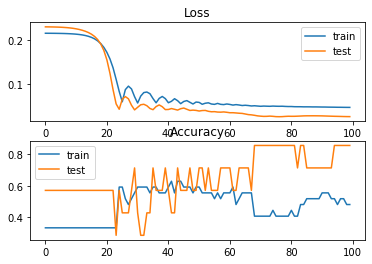

shape xtrain (27, 24) shape ytrain (27, 3) || shape xtest (7, 24) shape ytest (7, 3)
Progression........................................................................... 89.90%

---------------------------------------- Duel : BC-DVG:BC-FN:BC-RDG --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.625, Test: 0.500 loss:0.0875
elu funtion is worst ! Train: 0.292, Test: 0.000 loss:0.1063
selu funtion is worst ! Train: 0.417, Test: 0.667 loss:0.0851
no model for this duel !
shape xtrain (24, 24) shape ytrain (24, 3) || shape xtest (6, 24) shape ytest (6, 3)
Progression........................................................................... 90.91%

---------------------------------------- Duel : BC-FN:BC-VEC --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.150, Test: 0.167 loss:0.3587
elu funtion is worst ! Train: 0.150, Test: 0.167 loss:0.3587


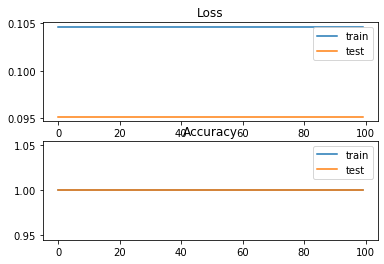

shape xtrain (28, 24) shape ytrain (28, 2) || shape xtest (8, 24) shape ytest (8, 2)
Progression........................................................................... 97.98%

---------------------------------------- Duel : BC-FG:BC-UMP --------------------------------------
Preparing input data... OK
Preparing labels... OK
relu funtion is worst ! Train: 0.358, Test: 0.429 loss:0.2953
elu funtion is worst ! Train: 0.358, Test: 0.429 loss:0.2953
selu funtion is worst ! Train: 0.642, Test: 0.571 loss:0.2533
no model for this duel !
shape xtrain (53, 24) shape ytrain (53, 2) || shape xtest (14, 24) shape ytest (14, 2)
Progression........................................................................... 98.99%

---------------------------------------- Duel : BC-COM --------------------------------------
pourcentage de petit dataset :  79.7872340425532
duel with no model :  ['BC-COM:BC-UD', 'BC-DVD:BC-FG', 'BC-COM:BC-DVD:BC-FN', 'BC-DVD:BC-FN:BC-RDG', 'BC-DVD:BC-SOC', 'BC-FG:BC-UD', 'B

In [10]:
#prepare les donnees


nbSmallDataset = 0
nbDataset = 0
noModel = []
activations = ['relu', 'elu', 'selu']
models = dict()
i=0


for duel in optDuels:
    print('\n---------------------------------------- Duel :',duel , '--------------------------------------')
    i+=1
    duel_ = sorted(duel.split(':'))
    if len(duel_)>=2:

        #Selecting data
        X_duel, y_duel  = extractDuelRaw(duel_)

        print('Preparing input data... ', end='')
        X = prepareInputDataExploded(X_duel)
        print('OK')

        print('Preparing labels... ', end='')
        y = prepareLabelsExploded(y_duel)
        print('OK')

        assert X.shape[0]==y.shape[0]
        
        if len(y.columns)<2:
            print("duel with same nuance !")
            print("skipped")
            continue

        if testna(X_duel) or testna(y_duel) or testna(X) or testna(y):
            print('nan in X_duel', testna(X_duel))
            print('nan in y_duel', testna(y_duel))
            print('nan in X', testna(X))
            print('nan in y', testna(y))


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8, random_state=42, shuffle=True)
        assert X_train.shape[0]==y_train.shape[0] and y_train.shape[1]==y.shape[1]
  
        for act in activations:
            tf.keras.backend.clear_session()

            model = tf.keras.Sequential()
            model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
            model.add(tf.keras.layers.Dense(32, activation=act))
            model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

            # opt = tf.keras.optimizers.Adagrad(learning_rate=0.00001)
            model.compile(loss='mse', optimizer='adamax', metrics=['accuracy'])


            history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100, verbose=0)

            _, train_acc = model.evaluate(X_train, y_train, verbose=0)
            _, test_acc  = model.evaluate(X_test , y_test , verbose=0)

            loss = history.history['loss'][-1]

            if criteriaRespected(test_acc, loss):
                # if already have a model for this duel
                if duel in models.keys():
                    if betterModel(duel, test_acc, loss):
                        # replace current model by a better one
                        print(act, 'function is better', 'Train: %.3f, Test: %.3f loss:%.4f' % (train_acc, test_acc, loss))
                        models[duel]= dict([('model', model)   , ('accuracy', (train_acc, test_acc)), ('loss', loss),
                                            ('activation', act), ('history', history), ('dataset', (X,y))
                                           ])
                    else:
                        print(act, 'function is not better', 'Train: %.3f, Test: %.3f loss:%.4f' % (train_acc, test_acc, loss))

                else:
                    #append new model
                    print(act, 'function used for the new model', 'Train: %.3f, Test: %.3f loss:%.4f' % (train_acc, test_acc, loss))
                    models[duel]= dict([('model', model)   , ('accuracy', (train_acc, test_acc)), ('loss', loss),
                                        ('activation', act), ('history', history), ('dataset', (X,y))
                                       ])
                    if duel in noModel:
                        #remove thje duel from the noModel list
                        noModel.pop(noModel.index(duel))
            else:
                print(act, 'funtion is worst !', 'Train: %.3f, Test: %.3f loss:%.4f' % (train_acc, test_acc, loss))
                if duel not in noModel+list(models.keys()):
                    noModel.append(duel)
            
        if duel not in noModel:
            history = getHistory(duel)

            # plot loss during training
            pyplot.subplot(211)
            pyplot.title('Loss')
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='test')
            pyplot.legend()
            
            # plot accuracy during training
            pyplot.subplot(212)
            pyplot.title('Accuracy')
            pyplot.plot(history.history['accuracy'], label='train')
            pyplot.plot(history.history['val_accuracy'], label='test')
            pyplot.legend()

        
            saveModel(getModel(duel), duel, getActivation(duel))
            # saveFigure()
            print('Train: %.3f, Test: %.3f loss:%.4f activation: %s' % (getTrainAccuracy(duel), getTestAccuracy(duel), getLoss(duel), getActivation(duel)))
            pyplot.show()
        else:
            print('no model for this duel !')




        if X_train.shape[0]<500:
            nbSmallDataset+=1
        nbDataset+=1
                
        

       
        print(f'shape xtrain {X_train.shape} shape ytrain {y_train.shape} || shape xtest {X_test.shape} shape ytest {y_test.shape}')
        print('Progression..........................................................................................................', 
                f'{(i/len(optDuels.keys()))*100:.2f}%')
        


print("pourcentage de petit dataset : ", (nbSmallDataset/nbDataset)*100)
print('duel with no model : ', noModel)


def saveAllModels(models,datasetDuels, activation, opti, count=None):
   
       


        # evaluate the model
       

        
        
       
        saveName = duel.replace(':','_') +'_'+opti+ '_train_' + f'{train_acc:.2f}'+ '_test_' + f'{test_acc:.2f}'+'_loss_'+ f'{hist[-1]:.4f}'
        model.save('models/'+activation+'/'+saveName)
        pyplot.savefig('models/saveFig/'+activation+'/'+ saveName +'.png')


    

